##This is used for viusalizing the trained embeddings

In [1]:
# Phu, Andrea and Watcher
# 2018 Spring
import numpy as np
import pandas as pd
import time
import os
import pickle
import string
import psutil
import sklearn

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from ggplot import *

import time
from sklearn.manifold import TSNE
import math


/home/chewang/.conda/envs/judge_emb/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/chewang/.conda/envs/judge_emb/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/chewang/.conda/envs/judge_emb/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
processed_data_path = '/data/Dropbox/judge_embedding_data_sp18'
all_data_save_path = os.path.join(processed_data_path,"finalized_all_data","all_data_dict.pkl")
all_data_support_save_path = os.path.join(processed_data_path,"finalized_all_data","all_data_dict_support.pkl")
all_data_df_save_path = os.path.join(processed_data_path,"finalized_all_data","all_data_df.h5")
finished_embedding_folder_path = os.path.join(processed_data_path,'finished_judge_embedding')
plot_save_path = '/data/Dropbox/judge_embedding_data_sp18/plots'

## read in data for each case

In [3]:
all_data_dict = pickle.load(open(all_data_save_path,"rb"))
topic_glove_emb = all_data_dict['topic_glove_emb'][0]
judgeId2Index = all_data_dict['judge_id_to_index'][0]
judgeIndex2Id = all_data_dict['judge_index_to_id'][0]
all_data_df = all_data_dict['data_df']
all_data_df[:4]

,caseid,year,middle_part,opinion_text,songername,judgeidentificationnumber,topic,geniss,opinion_vector,judge_embed_index,Circuit,date,affirmdummy,judge_decision
0,XB0PMNQNB5G0,1891,contentMajOp,"[0, 202, 1268, 13, 0, 4600, 3, 0, 247954, 128,...","PARDEE, DON A.",1830.0,Civil Procedure,4.0,"[-0.07445931306292275, 0.05843820821632856, -0...",0,5,1891-12-07,0.0,0
1,XFL757,1891,contentMajOp,"[15, 116, 4, 9238, 7, 22547, 3, 4092, 1219, 0,...","BROWN, HENRY BILLINGS",284.0,Civil Procedure,4.0,"[-0.07101038203845275, 0.029874279749715626, -...",1,6,1891-10-06,0.0,0
2,XB0PMRQNB5G0,1891,contentMajOp,"[215, 6, 68193, 3527, 255, 9670, 5, 12375, 3, ...","PARDEE, DON A.",1830.0,Contracts,7.0,"[-0.059691082627907024, 0.10039284279069777, -...",0,5,1891-12-07,0.0,0
3,XFL7KI,1891,contentMajOp,"[5, 0, 935, 4951, 5, 8151, 0, 4490, 3, 0, 305,...","LOCKE, JAMES WILLIAM",1410.0,Civil Procedure,4.0,"[-0.13210430623456784, 0.12352108086419746, -0...",2,5,1891-11-27,0.0,0


In [4]:
# we now read in the judge bio data
judge_bio_path = os.path.join(processed_data_path,"JudgesBioReshaped_TOUSE.dta")
judge_bio_df = pd.read_stata(judge_bio_path)


## define functions for plotting

In [19]:
def convertPublicLabel(label):
    if label == 1: # public
        return 'public'
    else:
        return 'private'
    
def convertYearLabelToDecade(label):
    return math.floor(label/10)*10 # e.g. 1931 is now 1930    

def get_df_plot(judge_bio_df,judgeIndex2Id):
    # return a dataframe containing all the 
    df_plot = pd.DataFrame()
    num_judges = len(judgeIndex2Id)
    df_plot['emb_index'] = [index for index in range(num_judges)]
    df_plot['gender'] = '' # gender: M/F
    df_plot['Circuitjudge'] = '' # circuit number
    df_plot['presidentname'] = ''
    df_plot['placeofbirthcity'] = ''
    df_plot['placeofbirthstate'] = ''
    df_plot['raceorethnicity'] = '' # White, Hispanic, etc
    df_plot['partyaffiliationofpresident'] = '' # Democratic, Republican, Reassignment
    df_plot['nameofschool1'] = ''
    df_plot['SchoolState1'] = ''
    df_plot['Public1'] = '' # public or private (convert from 0/1)
    df_plot['birthyear'] = '' # need conversion from year to maybe group by decade

    for judge_index in range(2099):
        judge_id = judgeIndex2Id[judge_index]
        judge_bio_rows = judge_bio_df.loc[judge_bio_df['judgeidentificationnumber']==judge_id]
        judge_bio_row = judge_bio_rows.iloc[0] # this is the first row
        df_plot.iat[judge_index,df_plot.columns.get_loc('gender')] = judge_bio_row['genderNew']
        df_plot.iat[judge_index,df_plot.columns.get_loc('Circuitjudge')] =str(int(judge_bio_row['Circuitjudge'])) 

        df_plot.iat[judge_index,df_plot.columns.get_loc('presidentname')] = judge_bio_row['presidentname']
        df_plot.iat[judge_index,df_plot.columns.get_loc('placeofbirthcity')] = judge_bio_row['placeofbirthcity']
        df_plot.iat[judge_index,df_plot.columns.get_loc('placeofbirthstate')] = judge_bio_row['placeofbirthstate']
        df_plot.iat[judge_index,df_plot.columns.get_loc('raceorethnicity')] = judge_bio_row['raceorethnicity']
        df_plot.iat[judge_index,df_plot.columns.get_loc('partyaffiliationofpresident')] = judge_bio_row['partyaffiliationofpresident']
        df_plot.iat[judge_index,df_plot.columns.get_loc('nameofschool1')] = judge_bio_row['nameofschool1']
        df_plot.iat[judge_index,df_plot.columns.get_loc('SchoolState1')] = judge_bio_row['SchoolState1']
        df_plot.iat[judge_index,df_plot.columns.get_loc('Public1')] =convertPublicLabel(judge_bio_row['Public1']) 
        df_plot.iat[judge_index,df_plot.columns.get_loc('birthyear')] = convertYearLabelToDecade(judge_bio_row['birthyear'])  
    return df_plot

In [44]:
def normalize_to_unit_emb(emb):
    # helper function used to normalize each vector in an
    # embedding matrix to be of unit length (might or might not be good)
    norms = np.linalg.norm(emb,axis=1).reshape(-1,1)
    normalized_emb = emb/norms
    return normalized_emb

## really want a function here that just take in a embedding matrix and 
## visualize it according to certain parameters

def get_combined_df_plot(emb,df_plot, normalize_to_unit_length=False, PCA_dim=100, 
                  tsne_verbose=1,  tsne_perp = 40, tsne_iter=2000):
    # before we visualize stuff
    # this part only needs to be called once on an embedding
    # basically get x,y values for scatter plot
    if normalize_to_unit_length:
        emb = normalize_to_unit_emb(emb)
    
    # first do pca
    pca_reducer = PCA(n_components=PCA_dim)
    pca_result = pca_reducer.fit_transform(emb)
    
    # do tsne
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=tsne_verbose, perplexity=tsne_perp, n_iter=tsne_iter)
    tsne_results = tsne.fit_transform(pca_result)

    # now we put plotting x,y values into the dataframe
    df_plot['x-tsne'] = tsne_results[:,0]
    df_plot['y-tsne'] = tsne_results[:,1]
    return df_plot
    

def visualize_judge_emb(df_plot,emb_title="judge embedding",
                       size=50,alpha=0.3,listOfColorLabels=[],save_to_file=False,
                        save_prefix="fig",save_path="plots"):
    # given an df_plot, this function will visualize it
    # emb should be in np array form, 2099xD
    # df_plot should be a combined df_plot
    
    # use get_combined_df_plot to get a combined df_plot first 
    # and then use this function to create figures
    
    # the listOfColorLabels decide what coloring we will use to plot
    # the length of this list is how many plots we will generate in the end
    
    figures = [] # don'ts ave ggplot obj, just save the figures
    # otherwise get funny errors
    
    if len(listOfColorLabels) < 1: # if no coloring label specified then just do grey figure
        chart = ggplot(df_plot, aes(x='x-tsne', y='y-tsne')) \
            + geom_point(size=size,alpha=alpha) \
            + ggtitle(emb_title)
        chart.make()# call make to make the plot
        fig = chart.fig # get reference to the figure, we can display this figure or save it as png
        figures.append(fig)
    
    for colorLabel in listOfColorLabels:
        # now we can do plotting
        chart = ggplot(df_plot, aes(x='x-tsne', y='y-tsne', color=colorLabel)) \
            + geom_point(size=size,alpha=alpha) \
            + ggtitle(emb_title)
        chart.make()# call make to make the plot
        fig = chart.fig # get reference to the figure, we can display this figure or save it as png
        figures.append(fig)
    if save_to_file:
        for i in range(len(figures)):
            savePath = os.path.join(save_path,save_prefix+"_"+str(i)+".png")
            figures[i].savefig(savePath)
    
    return figures

## first let's read in the trained embedding from disk

In [10]:
# judge emb trained with opinion vec, topic vec and ruling label
judge_emb_path = os.path.join(finished_embedding_folder_path,"trained_emb_May2.pkl")
judge_emb = pickle.load(open(judge_emb_path,"rb"))

In [21]:
# for naive judge embeddings

naive_judge_emb_path = os.path.join(finished_embedding_folder_path,"naive_judge_emb_dict.pkl")
naive_judge_emb_dict = pickle.load(open(naive_judge_emb_path,"rb"))
judge_emb = naive_judge_emb_dict['allyears']

In [ ]:
### here we read in judge embeddings produced by doc vecs that are centered by topic-year



In [22]:
# listOfColorLabels = ['gender','Circuitjudge','presidentname','placeofbirthstate',
#                      'raceorethnicity','partyaffiliationofpresident','SchoolState1',
#                      'Public1','birthyear']

listOfColorLabels_short = ['gender','Circuitjudge','presidentname',
                           'raceorethnicity','partyaffiliationofpresident','birthyear']
# we will not do cities since there are too many... can make the graph crush

## the following one cell is used to visualize an embedding in the simplest way
## When loaded judge embedding, run this cell to get plots

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2099 samples in 0.002s...
[t-SNE] Computed neighbors for 2099 samples in 0.140s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2099
[t-SNE] Computed conditional probabilities for sample 2000 / 2099
[t-SNE] Computed conditional probabilities for sample 2099 / 2099
[t-SNE] Mean sigma: 0.051865
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.195610
[t-SNE] Error after 1000 iterations: 1.335429


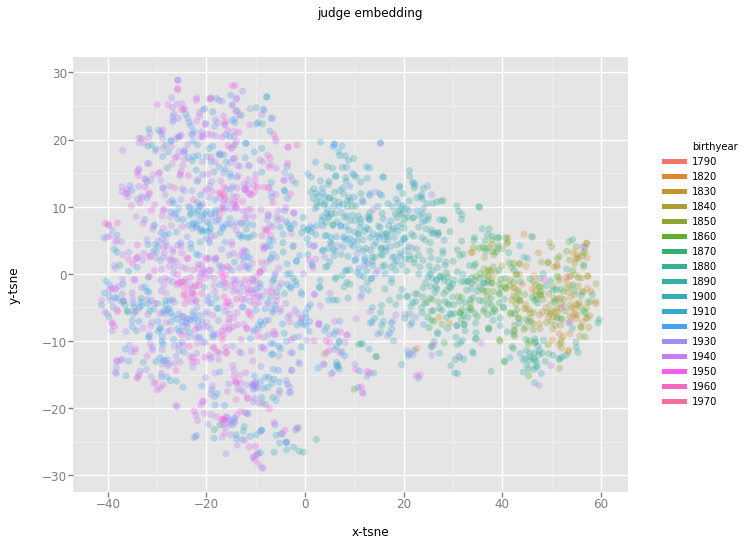

In [33]:
df_plot = get_df_plot(judge_bio_df,judgeIndex2Id) # df_plot contains each judge's info

df_plot_combined = get_combined_df_plot(judge_emb, df_plot, normalize_to_unit_length=False, PCA_dim=10, 
                  tsne_verbose=1,  tsne_perp = 50, tsne_iter=1000)
figures = visualize_judge_emb(df_plot_combined,emb_title="judge embedding",
                       size=50,alpha=0.3,listOfColorLabels=listOfColorLabels_short,save_to_file=False)

## Following are code to get a ton of plots

In [60]:
naive_judge_emb_path = os.path.join(finished_embedding_folder_path,"naive_judge_emb_dict.pkl")
naive_judge_emb_dict = pickle.load(open(naive_judge_emb_path,"rb"))
judge_emb = naive_judge_emb_dict['allyears']

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 2099 samples in 0.003s...
[t-SNE] Computed neighbors for 2099 samples in 0.366s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2099
[t-SNE] Computed conditional probabilities for sample 2000 / 2099
[t-SNE] Computed conditional probabilities for sample 2099 / 2099
[t-SNE] Mean sigma: 0.014044
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.021767
[t-SNE] Error after 1500 iterations: 1.776369
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 2099 samples in 0.004s...
[t-SNE] Computed neighbors for 2099 samples in 0.401s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2099
[t-SNE] Computed conditional probabilities for sample 2000 / 2099
[t-SNE] Computed conditional probabilities for sample 2099 / 2099
[t-SNE] Mean sigma: 0.015716
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.905731
[t-SNE] Error after 1500 iterations: 1.661458
[t-SNE] Computin

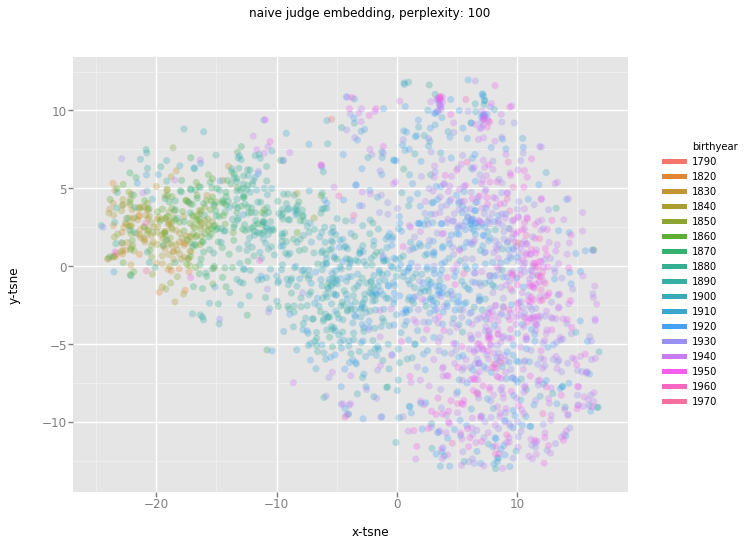

In [61]:
perp_list = [15,25,50,100]
figures_list_naive = []
n_iter = 1500
for perp in perp_list:
    df_plot = get_df_plot(judge_bio_df,judgeIndex2Id) # df_plot contains each judge's info

    df_plot_combined = get_combined_df_plot(judge_emb, df_plot, normalize_to_unit_length=True, PCA_dim=50, 
                      tsne_verbose=1,  tsne_perp = perp, tsne_iter=n_iter)
    figures = visualize_judge_emb(df_plot_combined,emb_title="naive judge embedding, perplexity: "+str(perp),
                           size=50,alpha=0.3,listOfColorLabels=listOfColorLabels_short,save_to_file=True,
                                 save_prefix="naive"+str(perp),save_path=plot_save_path)
    figures_list_naive.append(figures)
    

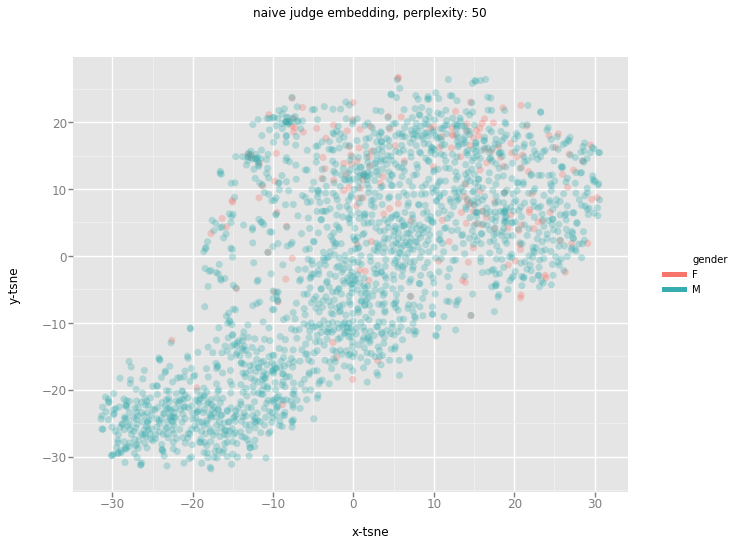

In [66]:
figures_list_naive[2][0]

In [63]:
judge_emb_path = os.path.join(finished_embedding_folder_path,"trained_emb_May2.pkl")
judge_emb = pickle.load(open(judge_emb_path,"rb"))

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 2099 samples in 0.003s...
[t-SNE] Computed neighbors for 2099 samples in 0.296s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2099
[t-SNE] Computed conditional probabilities for sample 2000 / 2099
[t-SNE] Computed conditional probabilities for sample 2099 / 2099
[t-SNE] Mean sigma: 0.086820
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.280945
[t-SNE] Error after 1500 iterations: 1.572981
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 2099 samples in 0.004s...
[t-SNE] Computed neighbors for 2099 samples in 0.313s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2099
[t-SNE] Computed conditional probabilities for sample 2000 / 2099
[t-SNE] Computed conditional probabilities for sample 2099 / 2099
[t-SNE] Mean sigma: 0.097247
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.199509
[t-SNE] Error after 1500 iterations: 1.438424
[t-SNE] Computin

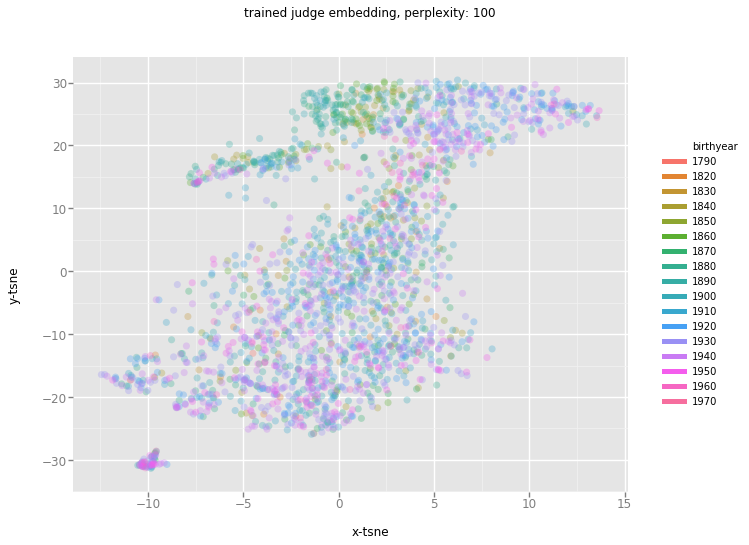

In [64]:
perp_list = [15,25,50,100]
figures_list_trained = []
n_iter = 1500
for perp in perp_list:
    df_plot = get_df_plot(judge_bio_df,judgeIndex2Id) # df_plot contains each judge's info

    df_plot_combined = get_combined_df_plot(judge_emb, df_plot, normalize_to_unit_length=True, PCA_dim=50, 
                      tsne_verbose=1,  tsne_perp = perp, tsne_iter=n_iter)
    figures = visualize_judge_emb(df_plot_combined,emb_title="trained judge embedding, perplexity: "+str(perp),
                           size=50,alpha=0.3,listOfColorLabels=listOfColorLabels_short,save_to_file=True,
                                 save_prefix="trained"+str(perp),save_path=plot_save_path)
    figures_list_trained.append(figures)

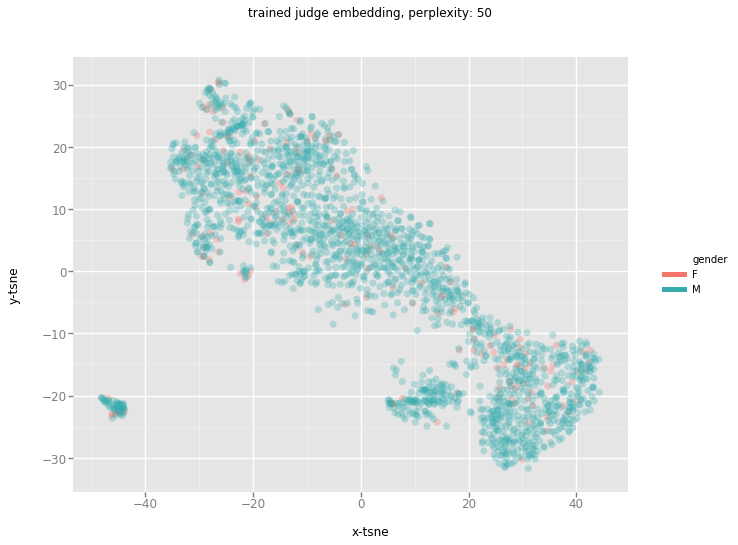

In [67]:
figures_list_trained[2][0]

## now we try to do demeaned visualizations

## We want to get mean vector for a bunch of label categories

In [68]:
def get_mean_dict(emb, df_labels, listOfLabels):
    # emb is NxD numpy array, df_labels should contain the labels 
    
    # for all the features specified in listOfLabels will
    # generate a mean vec for each category of that feature
    
    num_judges = emb.shape[0]
    num_dim = emb.shape[1]

    mean_dict = {}
    count_dict = {}
    for index in range(num_judges):
        thisBio = df_labels.iloc[index]
        
        for label in listOfLabels: # label is e.g. 'gender'
            labelValue = thisBio[label]
            
            dict_key = label+'-' + str(labelValue)
            if dict_key in mean_dict:
                mean_dict[dict_key] += emb[index]
                count_dict[dict_key] += 1
            else:# if this entry is not in dictionary yet
                mean_dict[dict_key] = np.zeros((num_dim))+ emb[index] # initialize new mean vector
                count_dict[dict_key] = 1
            
    # before we return the mean dictionary
    # we need to do an average by the count for each mean vec
    for k in mean_dict.keys():
        mean_dict[k] /= count_dict[k]
    return mean_dict


def get_demeaned_emb_copy(original_emb, df_labels, mean_dict, listOfLabels, label_to_use):
    # list of labels means which labels we want to demean
    # label_to_use is the label that will not get demeaned
    emb_copy = np.copy(original_emb)

    num_judges = emb_copy.shape[0]
    num_dim = emb_copy.shape[1]

    for index in range(num_judges):
        thisBio = df_labels.iloc[index]

        for label in listOfLabels:  # label is e.g. 'gender'
            if label == label_to_use:
                continue

            labelValue = thisBio[label]

            dict_key = label + '-' + str(labelValue)
            if dict_key in mean_dict:
                emb_copy[index, :] -= mean_dict[dict_key]
            else:  # if this entry is not in dictionary yet
                print("An error occured! Mean_dict key error.")
    # before we return the mean dictionary
    # we need to do an average by the count for each mean vec
    return emb_copy


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2099 samples in 0.005s...
[t-SNE] Computed neighbors for 2099 samples in 0.544s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2099
[t-SNE] Computed conditional probabilities for sample 2000 / 2099
[t-SNE] Computed conditional probabilities for sample 2099 / 2099
[t-SNE] Mean sigma: 0.004471
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.519264
[t-SNE] Error after 1500 iterations: 1.561974
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2099 samples in 0.004s...
[t-SNE] Computed neighbors for 2099 samples in 0.465s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2099
[t-SNE] Computed conditional probabilities for sample 2000 / 2099
[t-SNE] Computed conditional probabilities for sample 2099 / 2099
[t-SNE] Mean sigma: 0.004751
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.598732
[t-SNE] Error after 1500 iterations: 1.460809
[t-SNE] Comput

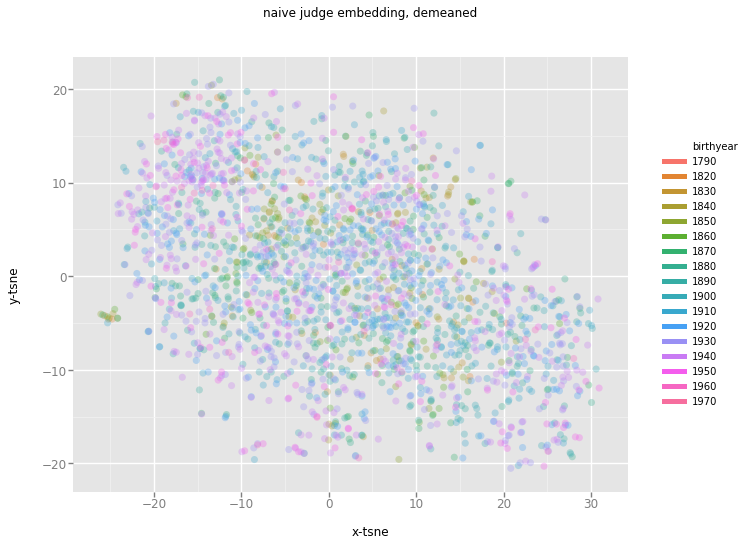

In [71]:
naive_judge_emb_path = os.path.join(finished_embedding_folder_path,"naive_judge_emb_dict.pkl")
naive_judge_emb_dict = pickle.load(open(naive_judge_emb_path,"rb"))
judge_emb = naive_judge_emb_dict['allyears']

for label_to_use in listOfColorLabels_short:
    mean_dict = get_mean_dict(judge_emb, df_plot, listOfColorLabels_short)
    df_plot = get_df_plot(judge_bio_df,judgeIndex2Id)

    demeaned_emb = get_demeaned_emb_copy(judge_emb,df_plot, mean_dict, listOfColorLabels_short, label_to_use)

    df_plot_combined = get_combined_df_plot(demeaned_emb, df_plot, normalize_to_unit_length=True, PCA_dim=50,
                      tsne_verbose=1,  tsne_perp = 50, tsne_iter=1500)
    figures = visualize_judge_emb(df_plot_combined,emb_title="naive judge embedding, demeaned",
                           size=50,alpha=0.3,listOfColorLabels=[label_to_use],save_to_file=True,
                                 save_prefix="naive_demean_"+str(label_to_use),save_path=plot_save_path)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2099 samples in 0.004s...
[t-SNE] Computed neighbors for 2099 samples in 0.458s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2099
[t-SNE] Computed conditional probabilities for sample 2000 / 2099
[t-SNE] Computed conditional probabilities for sample 2099 / 2099
[t-SNE] Mean sigma: 0.033888
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.740898
[t-SNE] Error after 1500 iterations: 1.316075
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2099 samples in 0.005s...
[t-SNE] Computed neighbors for 2099 samples in 0.489s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2099
[t-SNE] Computed conditional probabilities for sample 2000 / 2099
[t-SNE] Computed conditional probabilities for sample 2099 / 2099
[t-SNE] Mean sigma: 0.034066
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.456596
[t-SNE] Error after 1500 iterations: 1.266304
[t-SNE] Comput

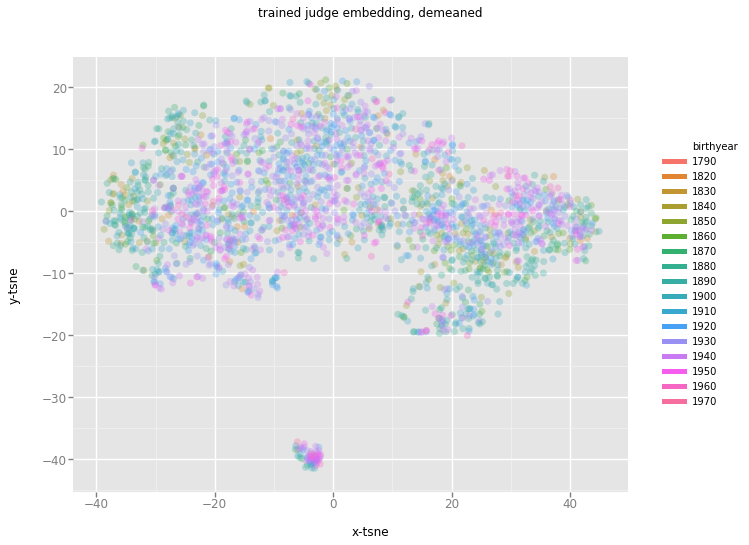

In [72]:
judge_emb_path = os.path.join(finished_embedding_folder_path,"trained_emb_May2.pkl")
judge_emb = pickle.load(open(judge_emb_path,"rb"))

for label_to_use in listOfColorLabels_short:
    mean_dict = get_mean_dict(judge_emb, df_plot, listOfColorLabels_short)
    df_plot = get_df_plot(judge_bio_df,judgeIndex2Id)

    demeaned_emb = get_demeaned_emb_copy(judge_emb,df_plot, mean_dict, listOfColorLabels_short, label_to_use)

    df_plot_combined = get_combined_df_plot(demeaned_emb, df_plot, normalize_to_unit_length=True, PCA_dim=50,
                      tsne_verbose=1,  tsne_perp = 50, tsne_iter=1500)
    figures2 = visualize_judge_emb(df_plot_combined,emb_title="trained judge embedding, demeaned",
                           size=50,alpha=0.3,listOfColorLabels=[label_to_use],save_to_file=True,
                                 save_prefix="trained_demean_"+str(label_to_use),save_path=plot_save_path)

In [ ]:
#I NEED TO SAVE THE FIGURES IN figures and figures2 manually they are not saved correctly last time

In [74]:
for i in range(len(figures)):
    savePath = os.path.join(plot_save_path,"naive_demean_"+str(i)+".png")
    figures[i].savefig(savePath)

In [ ]:
for i in range(len(figures2)):
    savePath = os.path.join(plot_save_path,"trained_demean_"+str(i)+".png")
    figures2[i].savefig(savePath)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2099 samples in 0.005s...
[t-SNE] Computed neighbors for 2099 samples in 0.513s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2099
[t-SNE] Computed conditional probabilities for sample 2000 / 2099
[t-SNE] Computed conditional probabilities for sample 2099 / 2099
[t-SNE] Mean sigma: 0.004751
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.605103
[t-SNE] Error after 3100 iterations: 1.471321


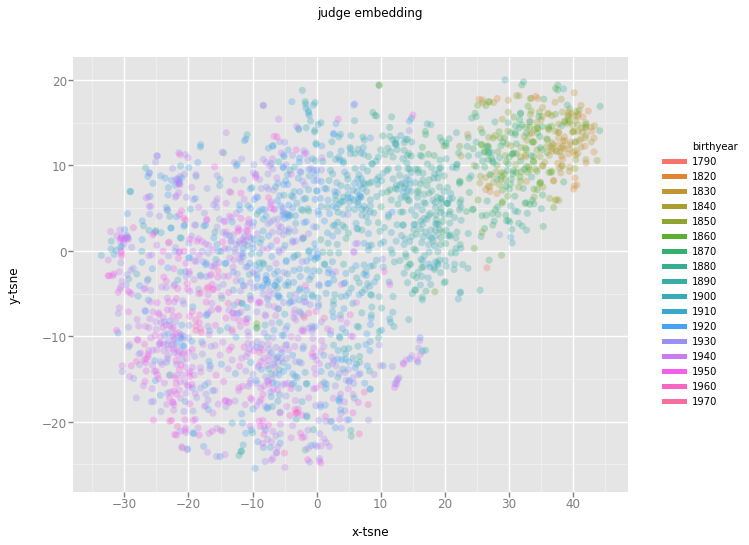

In [55]:
#TODO run this
label_to_use = 'Circuitjudge'

mean_dict = get_mean_dict(judge_emb, df_plot, listOfColorLabels_short)
df_plot = get_df_plot(judge_bio_df,judgeIndex2Id)

demeaned_emb = get_demeaned_emb_copy(judge_emb,df_plot, mean_dict, listOfColorLabels_short, label_to_use)

df_plot_combined = get_combined_df_plot(demeaned_emb, df_plot, normalize_to_unit_length=True, PCA_dim=50, 
                  tsne_verbose=1,  tsne_perp = 50, tsne_iter=5000)
figures = visualize_judge_emb(df_plot_combined,emb_title="judge embedding",
                       size=50,alpha=0.3,listOfColorLabels=listOfColorLabels_short)